# Sentiment Analysis on Product Reviews 

# 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lightgbm import LGBMClassifier
import nltk
nltk.download("punkt")
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from time import time
import joblib
import os
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Reading and Exploring Data

### Reading data

In [2]:
data = pd.read_csv(
    "data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
)

### First look of data

In [3]:
data.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


### Data Information

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories           28332 non-null  object 
 7   primaryCategories    28332 non-null  object 
 8   imageURLs            28332 non-null  object 
 9   keys                 28332 non-null  object 
 10  manufacturer         28332 non-null  object 
 11  manufacturerNumber   28332 non-null  object 
 12  reviews.date         28332 non-null  object 
 13  reviews.dateSeen     28332 non-null  object 
 14  reviews.didPurchase  9 non-null      object 
 15  reviews.doRecommend  16086 non-null 

### Statiscal Information

In [5]:
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating
count,4.100000e+01,16115.000000,28332.000000
mean,1.840066e+08,0.529321,4.514048
std,2.337036e+07,9.345017,0.934957
min,1.116244e+08,0.000000,1.000000
25%,1.843344e+08,0.000000,4.000000
50%,1.885078e+08,0.000000,5.000000
75%,1.988160e+08,0.000000,5.000000
max,2.085304e+08,621.000000,5.000000


### Missing Value Check

In [6]:
# Checking for percentage of null values
data.isnull().sum() / data.shape[0]

id                     0.000000
dateAdded              0.000000
dateUpdated            0.000000
name                   0.000000
asins                  0.000000
brand                  0.000000
categories             0.000000
primaryCategories      0.000000
imageURLs              0.000000
keys                   0.000000
manufacturer           0.000000
manufacturerNumber     0.000000
reviews.date           0.000000
reviews.dateSeen       0.000000
reviews.didPurchase    0.999682
reviews.doRecommend    0.432232
reviews.id             0.998553
reviews.numHelpful     0.431209
reviews.rating         0.000000
reviews.sourceURLs     0.000000
reviews.text           0.000000
reviews.title          0.000000
reviews.username       0.000000
sourceURLs             0.000000
dtype: float64

In [7]:
# # Filtering data where reviews and ratings are not null
# data = data[(~data['reviews.text'].isnull()) & (~data['reviews.rating'].isnull())]

### Duplicate Value Check

In [8]:
# Checking for duplicate values
print(f"Data shape before deleting duplicates: {data.shape}")
print(f"Data shape after deleting duplicates: {data.drop_duplicates().shape}")

Data shape before deleting duplicates: (28332, 24)
Data shape after deleting duplicates: (28332, 24)


In [9]:
# # Dropping duplicate values
# data = data.drop_duplicates()
# data = data.reset_index(drop=True)

### Word Cloud

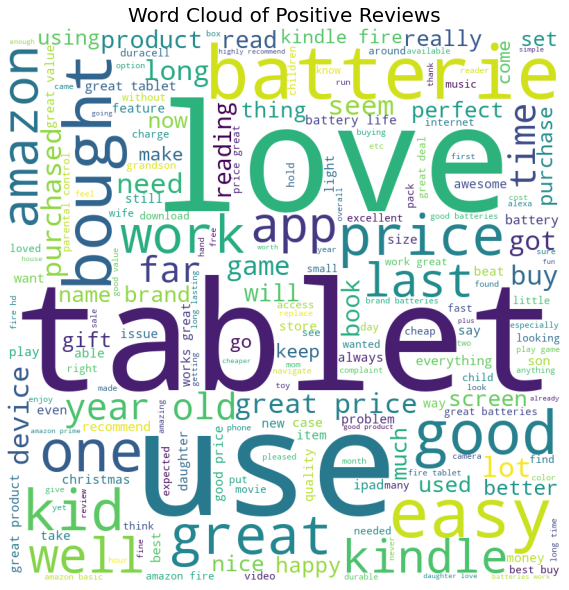

In [10]:
# Fetching positive reviews
pos_reviews = ""
stopwords = set(STOPWORDS)

for i in range(len(data)):
    if (data.loc[i, 'reviews.rating'] == 4) | (data.loc[i, 'reviews.rating'] == 5):
        review = data.loc[i, 'reviews.text']
        review = review.lower()
        review = review.split()
        pos_reviews += " ".join(review) + " "

# Creating WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(pos_reviews)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title("Word Cloud of Positive Reviews", 
         fontdict={'fontsize': 20})
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

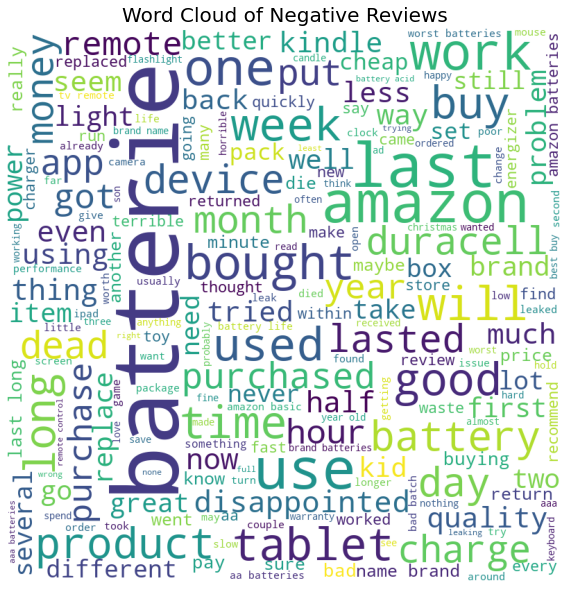

In [11]:
# Fetching negative reviews
neg_reviews = ''
for i in range(len(data)):
    if (data.loc[i, 'reviews.rating'] == 1) | (data.loc[i, 'reviews.rating'] == 2):
        review = data.loc[i, 'reviews.text']
        review = review.lower()
        review = review.split()
        neg_reviews += " ".join(review) + " "
# Creating WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(neg_reviews)
 
# Plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title("Word Cloud of Negative Reviews",
         fontdict={'fontsize': 20})
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Review Distribution

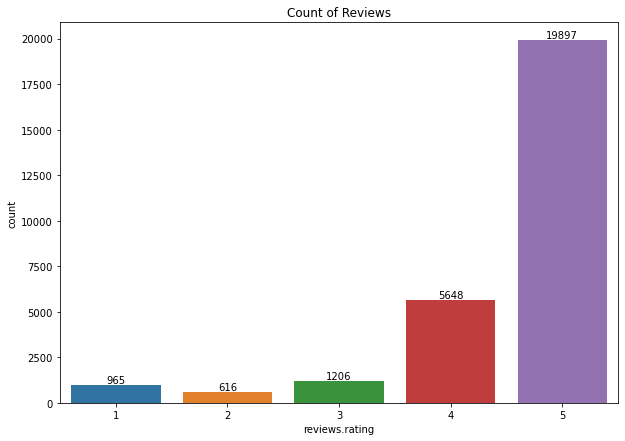

In [12]:
plt.figure(figsize=(10, 7))
ax = sns.countplot(x=data['reviews.rating'])
ax.bar_label(ax.containers[0])
plt.title('Count of Reviews')
plt.show()

# 3. Data Preprocessing

In [13]:
from nltk.corpus import stopwords

In [14]:
def generate_sentiment_scores(sentence):
    """
    This function generates a compound sentiment intensity score 
    for a given sentence.
    
    Args:
        sentence(str): A string of sentence.
        
    Returns:
        sentiment(float): Compound sentiment intensity score. 
                        Score > 0, positive.
                        Score < 0, negative.
                        Score = 0, neutral.
    """
    sid = SentimentIntensityAnalyzer()
    sentence = sentence.lower()
    sentiment = sid.polarity_scores(sentence)["compound"]
    return sentiment

In [15]:
def generate_stem(sentence):
    """
    This function generates the root word for each word
    in a given sentence.
    
    Args:
        sentence(str): A string of sentence.
        
    Returns:
        stems(list): A list of dictionaries in the format {word: root_word}
    """
    ps = PorterStemmer()
    stems = [{word: ps.stem(word)} for word in sentence]
    return stems

In [16]:
def generate_tokens(sentence):
    """
    This function generates tokens for each word in a sentence.
    
    Args:
        sentence(str): A string of sentence.
        
    Returns:
        tokens(list): A list of each word present in a sentence.
        
    """
    tokens = word_tokenize(sentence)
    return tokens

In [17]:
def preprocessing_pipeline(data):
    """
    This function preprocesses data with the following steps:
    1. Filters reviews from the data.
    2. Converts reviews into lowercase.
    3. Removes all symbols and punctuations.
    4. Removes excess white space.
    5. Tokenizes the each review.
    6. Generates stems for each word in review.
    7. Removes stop words from reviews.
    
    Args:
        data(pd.DataFrame): Raw data read from the csv file.
    
    Returns:
        stems(list): A list of dictionaries containing the stem word
                    and the root word.
        sentences(list): A list of tokenized reviews after removing
                        stop words.
    """
    # filtering required data
    reviews = data["reviews.text"]

    # converting the text to lower case
    reviews = reviews.str.lower()

    # replacing anything which is a digit and not a word or whitespace with " "
    reviews = reviews.str.replace("[^\w\s]|[\d]", " ", regex=True)

    # stripping excess spaces in text
    reviews = reviews.str.strip()

    # tokenizing words
    reviews = reviews.apply(generate_tokens)

    # stemmming
    stems = reviews.apply(generate_stem)

    # removing stop words
#     stopwords_data = list(set(stopwords.words("english")))
#     sentences = []
#     for review in tqdm(reviews.values):
#         sentence = []
#         for word in review:
#             if word not in stopwords_data:
#                 sentence.append(word)
#         sentences.append(sentence)
        
    # after stemming
    ps = PorterStemmer()
    stems = reviews.apply(lambda sentence: [ps.stem(word) for word in sentence])
    stopwords_data = list(set(stopwords.words('english')))
    sentences = []
    for review in tqdm(stems.values):
        sentence = []
        for word in review:
            if word not in stopwords_data:
                sentence.append(word)
        sentences.append(sentence)

    return sentences

In [18]:
def get_sentiment_scores(data):
    """
    This function takes in the raw data and generates 
    sentiment score based on the following rules:
    1. If review rating > 3 then sentiment score = 1
    2. If review rating < 3 then sentiment score = 0
    3. If review rating = 3 then we'll generate the sentiment score
        using our custom function.
    
    Args:
        data(pd.DataFrame): A dataframe of the raw data read from csv file.
        
    Returns:
        scores(list): A list of sentiment scores for each review.
    """
    scores = []
    for i in tqdm(range(len(data))):
        if data.loc[i, "reviews.rating"] == 3:
            sentiment_score = generate_sentiment_scores(data.loc[i, "reviews.text"])
            if sentiment_score > 0:
                sentiment_score = 1
            elif sentiment_score <= 0:
                sentiment_score = 0
        elif data.loc[i, "reviews.rating"] > 3:
            sentiment_score = 1
        else:
            sentiment_score = 0

        scores.append(sentiment_score)
    return scores

In [19]:
sentences = preprocessing_pipeline(data)
sentiment_scores = get_sentiment_scores(data)

  0%|          | 0/28332 [00:00<?, ?it/s]

  0%|          | 0/28332 [00:00<?, ?it/s]

### Creating Final DataFrame

In [20]:
final_df = pd.DataFrame(columns=["Reviews", "Sentiments"])
final_df["Reviews"] = sentences
final_df["Sentiments"] = sentiment_scores

In [21]:
final_df["Reviews"] = final_df["Reviews"].apply(lambda x: " ".join(x))

In [22]:
final_df.head()

,Reviews,Sentiments
0,order one item bad qualiti miss backup spring ...,0
1,bulk alway less expens way go product like,1
2,well duracel price happi,1
3,seem work well name brand batteri much better ...,1
4,batteri veri long last price great,1


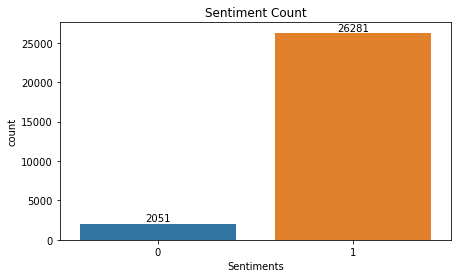

In [23]:
# Checking Sentiment Count
plt.figure(figsize=(7, 4))
ax = sns.countplot(x=final_df['Sentiments'])
ax.bar_label(ax.containers[0])
plt.title('Sentiment Count')
plt.show()

# Feature Extraction

### TF-IDF Vectorization

In [24]:
vectorizer = TfidfVectorizer(max_df=0.9)
vector = vectorizer.fit_transform(final_df["Reviews"])

### Dividing data into X and y

In [25]:
X = vector.toarray()
y = final_df["Sentiments"]

### Class Imbalance Correction

In [26]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

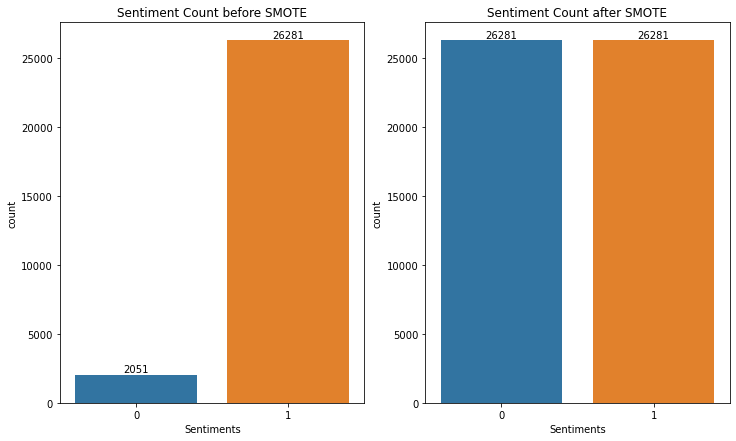

In [27]:
# Checking Sentiment Count
plt.figure(figsize=(12, 7))
plt.subplot(121)
ax1 = sns.countplot(x=final_df['Sentiments'])
ax1.bar_label(ax1.containers[0])
plt.title('Sentiment Count before SMOTE')
plt.subplot(122)
ax2 = sns.countplot(x=y_res)
ax2.bar_label(ax2.containers[0])
plt.title('Sentiment Count after SMOTE')
plt.show()

# Model Selection

### Train-Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

### Function to Evaluate Model

In [29]:
# Function to evaluate model
def model_eval(model, X_train, X_test, y_train, y_test, model_name='NaiveBayes'):
    """
    This function fits the model on given X_train, X_test, y_train and y_test.
    It then predicts for train and test data.
    Finally, it creates a dataframe consisting of below evaluation metrics for
    train and test sets:
    1. Accuracy
    2. ROC-AUC Score
    3. F1 Score
    4. Precision Score
    5. Recall Score
    
    Args:
        model: An ML model which is being used
        X_train(np.array): Train dependent variable values
        X_test(np.array): Test dependent variable values
        y_train(np.array): Train independent variable values
        y_test(np.array): Test independent variable values
        model_name(str): Name of the model
        
    Returns:
        eval_df(pd.DataFrame): A dataframe consisting of evaluation metrics for 
                            Train and Test sets. 
    """
    eval_df = pd.DataFrame(index=[model_name])
    
    start = time()
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    eval_df['Train Accuracy'] = accuracy_score(y_train, y_train_pred)
    eval_df['Test Accuracy'] = accuracy_score(y_test, y_test_pred)
    
    eval_df['Train F1 Score'] = f1_score(y_train, y_train_pred)
    eval_df['Test F1 Score'] = f1_score(y_test, y_test_pred)
    
    eval_df['Train Precision Score'] = precision_score(y_train, y_train_pred)
    eval_df['Test Precision Score'] = precision_score(y_test, y_test_pred)
    
    eval_df['Train Recall Score'] = recall_score(y_train, y_train_pred)
    eval_df['Test Recall Score'] = recall_score(y_test, y_test_pred)
    
    end = time()
    
    eval_df['Time Taken'] = round(end - start, 2)
    
    return eval_df.T

### Training Models
1. Gaussian Naive Bayes 
2. Logistic Regression 
3. Random Forrest Classifier
4. Light Gradient Boosting Model(LGBM) Classifier 

In [30]:
# Initializing models
nb = GaussianNB()
logit = LogisticRegression()
rf = RandomForestClassifier()
lgbm = LGBMClassifier()
models = {'Naive Bayes': nb,
         'Logistic Regression': logit,
         'Random Forrest': rf,
         'LGBM Classifier': lgbm}

In [31]:
# Creating Evaluation Dataframe for each model
eval_df = pd.DataFrame()
for name, model in tqdm(models.items()):
    df = model_eval(model, 
                    X_train, X_test, 
                    y_train, y_test, 
                    name)
    eval_df = pd.concat([eval_df, df], axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

### Model Evaluation

In [32]:
# Checking model performance
eval_df

,Naive Bayes,Logistic Regression,Random Forrest,LGBM Classifier
Train Accuracy,0.687460,0.944921,0.996742,0.961688
Test Accuracy,0.677637,0.940455,0.986112,0.956245
Train F1 Score,0.545417,0.943597,0.996737,0.960986
Test F1 Score,0.524217,0.939152,0.985988,0.955478
Train Precision Score,0.999873,0.966861,0.998235,0.978932
Test Precision Score,1.000000,0.960056,0.994771,0.972419
Train Recall Score,0.374982,0.921427,0.995244,0.943686
Test Recall Score,0.355213,0.919140,0.977359,0.939117
Time Taken,22.160000,40.050000,195.040000,8.970000


### Saving Models

In [33]:
model_names = list(models.keys())
model_names = [model.lower().replace(" ", "_") + ".sav" for model in model_names]

In [34]:
for (_, model), model_name in zip(models.items(), model_names):
    joblib.dump(model, os.path.join('models', model_name))

In [35]:
# Saving TF-IDF Vectorizer
joblib.dump(vectorizer, os.path.join('models', 'tfidf_vectorizer.sav'))

['models\\tfidf_vectorizer.sav']